# Modelling Exploration Notebook V1

This Notebook focuses on comparing different forecast models provided by GluonTS. <br /> 
Experiments were run using Python 3.9 and PyTorch 1.13. <br /> 
Compared were:
- DeepAR (Salinas et al. 2020): [torch impl](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/torch/model/deepar/estimator.py)
- DeepState (Rangapuram et al. 2018): [mx impl](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/deepstate/_estimator.py)
- MQ-CNN (Wen et al. 2017): [mx impl](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/seq2seq/_mq_dnn_estimator.py)

In [5]:
# Required Packages
# !pip install -r ./src/requirements.txt

In [6]:
# Imports experiment script
from src.forecast_experiment import run_experiment
from src.forecast_util import plot_forecast
# Import packages
from datetime import timedelta
import json

/opt/conda/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


## Experiment Overview

### Define Configuration Store

In [7]:
from sqlalchemy import create_engine, Column, Integer, Float, String, PickleType,  select
# from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import declarative_base
from sqlalchemy.orm import sessionmaker, relationship

In [8]:
Base = declarative_base()

class Forecast_Experiment(Base):
    __tablename__ = 'forecast_experiment'
    id = Column('id', Integer, primary_key=True)
    model = Column('model name', String(20))
    version = Column('version', Integer)
    data_config = Column('data_config', PickleType)
    model_config = Column('model_config', PickleType)
    MASE = Column('MASE', Float)
    MAPE = Column('MAPE', Float)
    RMSE = Column('RMSE', Float)
    wQL_10 = Column('wQL_10', Float)
    wQL_50 = Column('wQL_50', Float)
    wQL_90 = Column('wQL_90', Float)
    avg_wQL = Column('avg_wQL', Float)

In [9]:
# engine = create_engine('sqlite:///:memory:', echo=True)
engine = create_engine("sqlite:///./config/forecast_config_v2.db")

Base.metadata.create_all(bind=engine)
Session = sessionmaker(bind=engine)
session = Session()

### Explore Experiments

The model name follows this naming convention: {framework}_{model_name}. <br />
- The framework specifies the Machine Learning Framework used to implement the model (mxnet, torch, tensorflow)
- The model_name specifies the Algorithm used (e.g. DeepAR). 

The version field is used to track the stage of experiments as defined below. This means general progression of modelling insights as well as updated data sources.

- version 1: first exploration
    - "../data_engineering/financial_ts/indices.csv",
    - "../data_engineering/financial_ts/ww_gdp.csv",
    - "../data_engineering/timeseries_data/ts_dgelt_events.csv"
- version 2: specific exploration
    - "../data_engineering/financial_ts/indices.csv",
    - "../data_engineering/financial_ts/ww_gdp.csv",
    - "../data_engineering/timeseries_data/ts_gdelt_5k_per_year_data.csv"

In [31]:
# Query experiment Table and print results:
q1 = select(Forecast_Experiment).order_by(Forecast_Experiment.avg_wQL)
q1_result = session.execute(q1) 

for s in q1_result.scalars():
    print(f"""{s.model}: {s.version} 
        - model_config: {str(s.model_config)[1:-1].replace("'","")}:
        - MAPE: {s.MAPE},
        - avg_wQL: {s.avg_wQL},
        """
    )

torch_deepar: 1 
        - model_config: epochs: 1000, prediction_length: 20, num_layers: 8, hidden_size: 64, context_length: 56, lr: 0.001, weight_decay: 1e-08:
        - MAPE: 0.04679007808624215,
        - avg_wQL: 0.03054266891615841,
        
torch_deepar: 1 
        - model_config: epochs: 400, prediction_length: 56, num_layers: 2, hidden_size: 60, context_length: 200, lr: 0.001, weight_decay: 1e-08:
        - MAPE: 0.04398518378674155,
        - avg_wQL: 0.03393084310078053,
        
torch_deepar: 1 
        - model_config: epochs: 400, prediction_length: 56, num_layers: 2, hidden_size: 40, context_length: 200, lr: 0.001, weight_decay: 1e-08:
        - MAPE: 0.04867304946676913,
        - avg_wQL: 0.035919825705461,
        
torch_deepar: 1 
        - model_config: epochs: 400, prediction_length: 56, num_layers: 2, hidden_size: 40, context_length: 100, lr: 0.001, weight_decay: 1e-08:
        - MAPE: 0.05248577369460426,
        - avg_wQL: 0.04011049213329933,
        
torch_deep

### Migrate Experiments

The Experiments from the modelling_experimentation_v1 notebook were stored in two different Tables. <br />
I exported them to a json file and used the below code to read the file and store previous experiments in the new database with dynamic config attributes.

In [30]:
import json
 
# Opening JSON file
with open('data_v2.json') as json_file:
    data = json.load(json_file)

In [36]:
for e in data:
    experiment_config = Forecast_Experiment(
        model = e['name'],
        version = 1,
        data_config = {
            'target':e['target'],
            'past_rts_col':e['past_rts_col'],
            'windows':1,
        },
        model_config = {
            'epochs':e['epochs'],
            'prediction_length':e['prediction_length'],
            'num_layers':e['num_layers'],
            'hidden_size':e['hidden_size'],
            # 'context_length':e['context_length'],
            'lr':e['lr'],
            'weight_decay':e['weight_decay'],
        },
        MASE = e['MASE'],
        MAPE = e['MAPE'],
        RMSE = e['RMSE'],
        wQL_10 = e['wQL_10'],
        wQL_50 = e['wQL_50'],
        wQL_90 = e['wQL_90'],
        avg_wQL = e['avg_wQL']
    )
    session.add(experiment_config)
    session.commit()

## DeepAR ([torch](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/torch/model/deepar/estimator.py))

DeepAR is a methodology for producing accurate probabilistic forecasts, based on training an autoregressive recurrent neural network model on a large number of related time series.

In [10]:
from gluonts.torch import DeepAREstimator

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# Data specs
input_paths = [
    "../data_engineering/financial_ts/indices.csv",
    "../data_engineering/financial_ts/ww_gdp.csv",
    "../data_engineering/timeseries_data/ts_gdelt_5k_per_year_data.csv"
]
target_col = 'ts_S&P' # switch to ts_S&P
with open('./config/past_rts_cols_v2.json', 'r') as fp:
    past_rts_col = json.load(fp)['version_2']
windows = 6
 
# epochs: 400, prediction_length: 56, num_layers: 2, hidden_size: 60, context_length: 200, lr: 0.001, weight_decay: 1e-08

# Estimator specs
version = 2
prediction_length=56
max_epochs = 700
num_layers=2
hidden_size=20
context_length = 400 
weight_decay = 1e-8
lr = 0.001
offset = -(prediction_length*windows)

# Trainer specs
accelerator = "cpu"
devices = "auto"

In [12]:
# Define estimator
deepar_estimator = DeepAREstimator(
    prediction_length=prediction_length,
    num_layers=num_layers,  
    hidden_size=hidden_size, 
    weight_decay=weight_decay,
    context_length=context_length,
    lr = lr,
    freq="W",
    trainer_kwargs={
        "max_epochs": max_epochs, 
        "accelerator":accelerator, 
        "devices":devices,
    }
)

In [ ]:
# Start Experiment
forecasts, tss, agg_metrics = run_experiment(
    input_paths=input_paths,
    target_col=target_col,
    prediction_length=prediction_length,
    windows=windows,
    offset = offset,
    past_rts_col=past_rts_col,
    estimator=deepar_estimator,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type        | Params | In sizes | Out sizes   
-------------------

Epoch 0: : 50it [00:19,  2.60it/s, v_num=97, train_loss=5.730]

Epoch 0, global step 50: 'train_loss' reached 5.73026 (best 5.73026), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: : 50it [00:22,  2.19it/s, v_num=97, train_loss=4.920]

Epoch 1, global step 100: 'train_loss' reached 4.92018 (best 4.92018), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: : 50it [00:19,  2.61it/s, v_num=97, train_loss=3.940]

Epoch 2, global step 150: 'train_loss' reached 3.94330 (best 3.94330), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: : 50it [00:18,  2.65it/s, v_num=97, train_loss=3.770]

Epoch 3, global step 200: 'train_loss' reached 3.77280 (best 3.77280), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: : 50it [00:20,  2.49it/s, v_num=97, train_loss=3.680]

Epoch 4, global step 250: 'train_loss' reached 3.67978 (best 3.67978), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: : 50it [00:22,  2.20it/s, v_num=97, train_loss=3.730]

Epoch 5, global step 300: 'train_loss' was not in top 1


Epoch 6: : 50it [00:22,  2.23it/s, v_num=97, train_loss=3.680]

Epoch 6, global step 350: 'train_loss' reached 3.67901 (best 3.67901), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: : 50it [00:22,  2.27it/s, v_num=97, train_loss=3.550]

Epoch 7, global step 400: 'train_loss' reached 3.54569 (best 3.54569), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: : 50it [00:18,  2.65it/s, v_num=97, train_loss=3.650]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: : 50it [00:18,  2.67it/s, v_num=97, train_loss=3.580]

Epoch 9, global step 500: 'train_loss' was not in top 1


Epoch 10: : 50it [00:19,  2.55it/s, v_num=97, train_loss=3.560]

Epoch 10, global step 550: 'train_loss' was not in top 1


Epoch 11: : 50it [00:19,  2.58it/s, v_num=97, train_loss=3.570]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: : 50it [00:21,  2.33it/s, v_num=97, train_loss=3.600]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: : 50it [00:22,  2.25it/s, v_num=97, train_loss=3.480]

Epoch 13, global step 700: 'train_loss' reached 3.48476 (best 3.48476), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=13-step=700.ckpt' as top 1


Epoch 14: : 50it [00:22,  2.24it/s, v_num=97, train_loss=3.470]

Epoch 14, global step 750: 'train_loss' reached 3.46698 (best 3.46698), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=14-step=750.ckpt' as top 1


Epoch 15: : 50it [00:19,  2.54it/s, v_num=97, train_loss=3.450]

Epoch 15, global step 800: 'train_loss' reached 3.44587 (best 3.44587), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=15-step=800.ckpt' as top 1


Epoch 16: : 50it [00:18,  2.66it/s, v_num=97, train_loss=3.460]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: : 50it [00:22,  2.21it/s, v_num=97, train_loss=3.470]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: : 50it [00:22,  2.26it/s, v_num=97, train_loss=3.390]

Epoch 18, global step 950: 'train_loss' reached 3.39295 (best 3.39295), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=18-step=950.ckpt' as top 1


Epoch 19: : 50it [00:20,  2.40it/s, v_num=97, train_loss=3.410]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: : 50it [00:18,  2.73it/s, v_num=97, train_loss=3.420]

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: : 50it [00:18,  2.64it/s, v_num=97, train_loss=3.380]

Epoch 21, global step 1100: 'train_loss' reached 3.37602 (best 3.37602), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=21-step=1100.ckpt' as top 1


Epoch 22: : 50it [00:18,  2.63it/s, v_num=97, train_loss=3.510]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: : 50it [00:19,  2.61it/s, v_num=97, train_loss=3.440]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: : 50it [00:18,  2.68it/s, v_num=97, train_loss=3.460]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: : 50it [00:18,  2.66it/s, v_num=97, train_loss=3.330]

Epoch 25, global step 1300: 'train_loss' reached 3.32899 (best 3.32899), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=25-step=1300.ckpt' as top 1


Epoch 26: : 50it [00:21,  2.38it/s, v_num=97, train_loss=3.480]

Epoch 26, global step 1350: 'train_loss' was not in top 1


Epoch 27: : 50it [00:19,  2.61it/s, v_num=97, train_loss=3.370]

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: : 50it [00:18,  2.73it/s, v_num=97, train_loss=3.500]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: : 50it [00:18,  2.68it/s, v_num=97, train_loss=3.400]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: : 50it [00:19,  2.59it/s, v_num=97, train_loss=3.400]

Epoch 30, global step 1550: 'train_loss' was not in top 1


Epoch 31: : 50it [00:19,  2.58it/s, v_num=97, train_loss=3.410]

Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: : 50it [00:21,  2.36it/s, v_num=97, train_loss=3.400]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: : 50it [00:20,  2.45it/s, v_num=97, train_loss=3.340]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: : 50it [00:18,  2.65it/s, v_num=97, train_loss=3.370]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: : 50it [00:19,  2.60it/s, v_num=97, train_loss=3.390]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: : 50it [00:18,  2.64it/s, v_num=97, train_loss=3.330]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: : 50it [00:20,  2.43it/s, v_num=97, train_loss=3.250]

Epoch 37, global step 1900: 'train_loss' reached 3.24975 (best 3.24975), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=37-step=1900.ckpt' as top 1


Epoch 38: : 50it [00:20,  2.45it/s, v_num=97, train_loss=3.210]

Epoch 38, global step 1950: 'train_loss' reached 3.20607 (best 3.20607), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=38-step=1950.ckpt' as top 1


Epoch 39: : 50it [00:18,  2.66it/s, v_num=97, train_loss=3.210]

Epoch 39, global step 2000: 'train_loss' was not in top 1


Epoch 40: : 50it [00:18,  2.65it/s, v_num=97, train_loss=3.290]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: : 50it [00:18,  2.64it/s, v_num=97, train_loss=3.190]

Epoch 41, global step 2100: 'train_loss' reached 3.19138 (best 3.19138), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=41-step=2100.ckpt' as top 1


Epoch 42: : 50it [00:18,  2.66it/s, v_num=97, train_loss=3.330]

Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: : 50it [00:21,  2.36it/s, v_num=97, train_loss=3.110]

Epoch 43, global step 2200: 'train_loss' reached 3.11281 (best 3.11281), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=43-step=2200.ckpt' as top 1


Epoch 44: : 50it [00:22,  2.24it/s, v_num=97, train_loss=3.240]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: : 50it [00:19,  2.60it/s, v_num=97, train_loss=3.200]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: : 50it [00:19,  2.62it/s, v_num=97, train_loss=3.150]

Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: : 50it [00:19,  2.54it/s, v_num=97, train_loss=3.260]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: : 50it [00:21,  2.32it/s, v_num=97, train_loss=3.250]

Epoch 48, global step 2450: 'train_loss' was not in top 1


Epoch 49: : 50it [00:18,  2.73it/s, v_num=97, train_loss=3.090]

Epoch 49, global step 2500: 'train_loss' reached 3.09168 (best 3.09168), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=49-step=2500.ckpt' as top 1


Epoch 50: : 50it [00:18,  2.69it/s, v_num=97, train_loss=3.070]

Epoch 50, global step 2550: 'train_loss' reached 3.07176 (best 3.07176), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=50-step=2550.ckpt' as top 1


Epoch 51: : 50it [00:19,  2.51it/s, v_num=97, train_loss=3.190]

Epoch 51, global step 2600: 'train_loss' was not in top 1


Epoch 52: : 50it [00:19,  2.63it/s, v_num=97, train_loss=3.180]

Epoch 52, global step 2650: 'train_loss' was not in top 1


Epoch 53: : 50it [00:18,  2.65it/s, v_num=97, train_loss=3.100]

Epoch 53, global step 2700: 'train_loss' was not in top 1


Epoch 54: : 50it [00:18,  2.66it/s, v_num=97, train_loss=3.200]

Epoch 54, global step 2750: 'train_loss' was not in top 1


Epoch 55: : 50it [00:19,  2.55it/s, v_num=97, train_loss=3.200]

Epoch 55, global step 2800: 'train_loss' was not in top 1


Epoch 56: : 50it [00:22,  2.25it/s, v_num=97, train_loss=3.240]

Epoch 56, global step 2850: 'train_loss' was not in top 1


Epoch 57: : 50it [00:22,  2.26it/s, v_num=97, train_loss=3.170]

Epoch 57, global step 2900: 'train_loss' was not in top 1


Epoch 58: : 50it [00:22,  2.27it/s, v_num=97, train_loss=3.200]

Epoch 58, global step 2950: 'train_loss' was not in top 1


Epoch 59: : 50it [00:20,  2.45it/s, v_num=97, train_loss=3.170]

Epoch 59, global step 3000: 'train_loss' was not in top 1


Epoch 60: : 50it [00:22,  2.22it/s, v_num=97, train_loss=3.250]

Epoch 60, global step 3050: 'train_loss' was not in top 1


Epoch 61: : 50it [00:19,  2.56it/s, v_num=97, train_loss=3.180]

Epoch 61, global step 3100: 'train_loss' was not in top 1


Epoch 62: : 50it [00:20,  2.49it/s, v_num=97, train_loss=3.180]

Epoch 62, global step 3150: 'train_loss' was not in top 1


Epoch 63: : 50it [00:19,  2.61it/s, v_num=97, train_loss=3.130]

Epoch 63, global step 3200: 'train_loss' was not in top 1


Epoch 64: : 50it [00:19,  2.55it/s, v_num=97, train_loss=3.170]

Epoch 64, global step 3250: 'train_loss' was not in top 1


Epoch 65: : 50it [00:19,  2.60it/s, v_num=97, train_loss=3.170]

Epoch 65, global step 3300: 'train_loss' was not in top 1


Epoch 66: : 50it [00:18,  2.66it/s, v_num=97, train_loss=3.140]

Epoch 66, global step 3350: 'train_loss' was not in top 1


Epoch 67: : 50it [00:18,  2.65it/s, v_num=97, train_loss=3.170]

Epoch 67, global step 3400: 'train_loss' was not in top 1


Epoch 68: : 50it [00:22,  2.23it/s, v_num=97, train_loss=3.130]

Epoch 68, global step 3450: 'train_loss' was not in top 1


Epoch 69: : 50it [00:19,  2.59it/s, v_num=97, train_loss=3.040]

Epoch 69, global step 3500: 'train_loss' reached 3.04210 (best 3.04210), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=69-step=3500.ckpt' as top 1


Epoch 70: : 50it [00:19,  2.56it/s, v_num=97, train_loss=3.040]

Epoch 70, global step 3550: 'train_loss' was not in top 1


Epoch 71: : 50it [00:21,  2.29it/s, v_num=97, train_loss=3.250]

Epoch 71, global step 3600: 'train_loss' was not in top 1


Epoch 72: : 50it [00:21,  2.37it/s, v_num=97, train_loss=3.120]

Epoch 72, global step 3650: 'train_loss' was not in top 1


Epoch 73: : 50it [00:18,  2.71it/s, v_num=97, train_loss=3.070]

Epoch 73, global step 3700: 'train_loss' was not in top 1


Epoch 74: : 50it [00:18,  2.68it/s, v_num=97, train_loss=3.130]

Epoch 74, global step 3750: 'train_loss' was not in top 1


Epoch 75: : 50it [00:21,  2.35it/s, v_num=97, train_loss=3.130]

Epoch 75, global step 3800: 'train_loss' was not in top 1


Epoch 76: : 50it [00:21,  2.32it/s, v_num=97, train_loss=3.060]

Epoch 76, global step 3850: 'train_loss' was not in top 1


Epoch 77: : 50it [00:19,  2.53it/s, v_num=97, train_loss=3.170]

Epoch 77, global step 3900: 'train_loss' was not in top 1


Epoch 78: : 50it [00:18,  2.70it/s, v_num=97, train_loss=2.990]

Epoch 78, global step 3950: 'train_loss' reached 2.98756 (best 2.98756), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=78-step=3950.ckpt' as top 1


Epoch 79: : 50it [00:18,  2.67it/s, v_num=97, train_loss=3.050]

Epoch 79, global step 4000: 'train_loss' was not in top 1


Epoch 80: : 50it [00:18,  2.73it/s, v_num=97, train_loss=3.120]

Epoch 80, global step 4050: 'train_loss' was not in top 1


Epoch 81: : 50it [00:18,  2.74it/s, v_num=97, train_loss=3.130]

Epoch 81, global step 4100: 'train_loss' was not in top 1


Epoch 82: : 50it [00:20,  2.49it/s, v_num=97, train_loss=3.140]

Epoch 82, global step 4150: 'train_loss' was not in top 1


Epoch 83: : 50it [00:18,  2.71it/s, v_num=97, train_loss=3.100]

Epoch 83, global step 4200: 'train_loss' was not in top 1


Epoch 84: : 50it [00:18,  2.75it/s, v_num=97, train_loss=3.090]

Epoch 84, global step 4250: 'train_loss' was not in top 1


Epoch 85: : 50it [00:18,  2.75it/s, v_num=97, train_loss=3.070]

Epoch 85, global step 4300: 'train_loss' was not in top 1


Epoch 86: : 50it [00:18,  2.74it/s, v_num=97, train_loss=3.110]

Epoch 86, global step 4350: 'train_loss' was not in top 1


Epoch 87: : 50it [00:17,  2.81it/s, v_num=97, train_loss=3.140]

Epoch 87, global step 4400: 'train_loss' was not in top 1


Epoch 88: : 50it [00:18,  2.69it/s, v_num=97, train_loss=3.100]

Epoch 88, global step 4450: 'train_loss' was not in top 1


Epoch 89: : 50it [00:18,  2.75it/s, v_num=97, train_loss=3.090]

Epoch 89, global step 4500: 'train_loss' was not in top 1


Epoch 90: : 50it [00:21,  2.38it/s, v_num=97, train_loss=3.040]

Epoch 90, global step 4550: 'train_loss' was not in top 1


Epoch 91: : 50it [00:20,  2.48it/s, v_num=97, train_loss=3.010]

Epoch 91, global step 4600: 'train_loss' was not in top 1


Epoch 92: : 50it [00:18,  2.69it/s, v_num=97, train_loss=3.060]

Epoch 92, global step 4650: 'train_loss' was not in top 1


Epoch 93: : 50it [00:18,  2.73it/s, v_num=97, train_loss=3.110]

Epoch 93, global step 4700: 'train_loss' was not in top 1


Epoch 94: : 50it [00:18,  2.76it/s, v_num=97, train_loss=3.090]

Epoch 94, global step 4750: 'train_loss' was not in top 1


Epoch 95: : 50it [00:19,  2.58it/s, v_num=97, train_loss=3.100]

Epoch 95, global step 4800: 'train_loss' was not in top 1


Epoch 96: : 50it [00:19,  2.55it/s, v_num=97, train_loss=3.130]

Epoch 96, global step 4850: 'train_loss' was not in top 1


Epoch 97: : 50it [00:18,  2.71it/s, v_num=97, train_loss=3.000]

Epoch 97, global step 4900: 'train_loss' was not in top 1


Epoch 98: : 50it [00:20,  2.46it/s, v_num=97, train_loss=3.080]

Epoch 98, global step 4950: 'train_loss' was not in top 1


Epoch 99: : 50it [00:21,  2.29it/s, v_num=97, train_loss=3.080]

Epoch 99, global step 5000: 'train_loss' was not in top 1


Epoch 100: : 50it [00:20,  2.38it/s, v_num=97, train_loss=3.090]

Epoch 100, global step 5050: 'train_loss' was not in top 1


Epoch 101: : 50it [00:18,  2.75it/s, v_num=97, train_loss=3.070]

Epoch 101, global step 5100: 'train_loss' was not in top 1


Epoch 102: : 50it [00:18,  2.73it/s, v_num=97, train_loss=3.100]

Epoch 102, global step 5150: 'train_loss' was not in top 1


Epoch 103: : 50it [00:18,  2.70it/s, v_num=97, train_loss=3.130]

Epoch 103, global step 5200: 'train_loss' was not in top 1


Epoch 104: : 50it [00:17,  2.78it/s, v_num=97, train_loss=3.040]

Epoch 104, global step 5250: 'train_loss' was not in top 1


Epoch 105: : 50it [00:18,  2.65it/s, v_num=97, train_loss=3.090]

Epoch 105, global step 5300: 'train_loss' was not in top 1


Epoch 106: : 50it [00:18,  2.72it/s, v_num=97, train_loss=3.080]

Epoch 106, global step 5350: 'train_loss' was not in top 1


Epoch 107: : 50it [00:21,  2.33it/s, v_num=97, train_loss=3.070]

Epoch 107, global step 5400: 'train_loss' was not in top 1


Epoch 108: : 50it [00:21,  2.29it/s, v_num=97, train_loss=3.100]

Epoch 108, global step 5450: 'train_loss' was not in top 1


Epoch 109: : 50it [00:22,  2.25it/s, v_num=97, train_loss=3.030]

Epoch 109, global step 5500: 'train_loss' was not in top 1


Epoch 110: : 50it [00:20,  2.41it/s, v_num=97, train_loss=3.120]

Epoch 110, global step 5550: 'train_loss' was not in top 1


Epoch 111: : 50it [00:18,  2.65it/s, v_num=97, train_loss=3.130]

Epoch 111, global step 5600: 'train_loss' was not in top 1


Epoch 112: : 50it [00:19,  2.56it/s, v_num=97, train_loss=3.110]

Epoch 112, global step 5650: 'train_loss' was not in top 1


Epoch 113: : 50it [00:19,  2.62it/s, v_num=97, train_loss=3.110]

Epoch 113, global step 5700: 'train_loss' was not in top 1


Epoch 114: : 50it [00:19,  2.61it/s, v_num=97, train_loss=3.010]

Epoch 114, global step 5750: 'train_loss' was not in top 1


Epoch 115: : 50it [00:19,  2.51it/s, v_num=97, train_loss=3.070]

Epoch 115, global step 5800: 'train_loss' was not in top 1


Epoch 116: : 50it [00:18,  2.66it/s, v_num=97, train_loss=3.040]

Epoch 116, global step 5850: 'train_loss' was not in top 1


Epoch 117: : 50it [00:19,  2.54it/s, v_num=97, train_loss=3.000]

Epoch 117, global step 5900: 'train_loss' was not in top 1


Epoch 118: : 50it [00:19,  2.56it/s, v_num=97, train_loss=3.060]

Epoch 118, global step 5950: 'train_loss' was not in top 1


Epoch 119: : 50it [00:19,  2.62it/s, v_num=97, train_loss=3.050]

Epoch 119, global step 6000: 'train_loss' was not in top 1


Epoch 120: : 50it [00:22,  2.23it/s, v_num=97, train_loss=3.120]

Epoch 120, global step 6050: 'train_loss' was not in top 1


Epoch 121: : 50it [00:18,  2.68it/s, v_num=97, train_loss=3.030]

Epoch 121, global step 6100: 'train_loss' was not in top 1


Epoch 122: : 50it [00:18,  2.67it/s, v_num=97, train_loss=3.070]

Epoch 122, global step 6150: 'train_loss' was not in top 1


Epoch 123: : 50it [00:21,  2.36it/s, v_num=97, train_loss=2.980]

Epoch 123, global step 6200: 'train_loss' reached 2.97546 (best 2.97546), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=123-step=6200.ckpt' as top 1


Epoch 124: : 50it [00:22,  2.21it/s, v_num=97, train_loss=3.050]

Epoch 124, global step 6250: 'train_loss' was not in top 1


Epoch 125: : 50it [00:21,  2.28it/s, v_num=97, train_loss=3.090]

Epoch 125, global step 6300: 'train_loss' was not in top 1


Epoch 126: : 50it [00:22,  2.27it/s, v_num=97, train_loss=3.070]

Epoch 126, global step 6350: 'train_loss' was not in top 1


Epoch 127: : 50it [00:20,  2.42it/s, v_num=97, train_loss=3.050]

Epoch 127, global step 6400: 'train_loss' was not in top 1


Epoch 128: : 50it [00:21,  2.32it/s, v_num=97, train_loss=3.160]

Epoch 128, global step 6450: 'train_loss' was not in top 1


Epoch 129: : 50it [00:18,  2.64it/s, v_num=97, train_loss=3.110]

Epoch 129, global step 6500: 'train_loss' was not in top 1


Epoch 130: : 50it [00:18,  2.70it/s, v_num=97, train_loss=3.120]

Epoch 130, global step 6550: 'train_loss' was not in top 1


Epoch 131: : 50it [00:18,  2.74it/s, v_num=97, train_loss=3.030]

Epoch 131, global step 6600: 'train_loss' was not in top 1


Epoch 132: : 50it [00:18,  2.76it/s, v_num=97, train_loss=2.990]

Epoch 132, global step 6650: 'train_loss' was not in top 1


Epoch 133: : 50it [00:18,  2.71it/s, v_num=97, train_loss=3.020]

Epoch 133, global step 6700: 'train_loss' was not in top 1


Epoch 134: : 50it [00:18,  2.69it/s, v_num=97, train_loss=3.030]

Epoch 134, global step 6750: 'train_loss' was not in top 1


Epoch 135: : 50it [00:18,  2.65it/s, v_num=97, train_loss=3.170]

Epoch 135, global step 6800: 'train_loss' was not in top 1


Epoch 136: : 50it [00:19,  2.58it/s, v_num=97, train_loss=2.990]

Epoch 136, global step 6850: 'train_loss' was not in top 1


Epoch 137: : 50it [00:21,  2.30it/s, v_num=97, train_loss=3.050]

Epoch 137, global step 6900: 'train_loss' was not in top 1


Epoch 138: : 50it [00:18,  2.67it/s, v_num=97, train_loss=3.070]

Epoch 138, global step 6950: 'train_loss' was not in top 1


Epoch 139: : 50it [00:18,  2.73it/s, v_num=97, train_loss=3.080]

Epoch 139, global step 7000: 'train_loss' was not in top 1


Epoch 140: : 50it [00:18,  2.72it/s, v_num=97, train_loss=3.030]

Epoch 140, global step 7050: 'train_loss' was not in top 1


Epoch 141: : 50it [00:18,  2.74it/s, v_num=97, train_loss=3.090]

Epoch 141, global step 7100: 'train_loss' was not in top 1


Epoch 142: : 50it [00:18,  2.72it/s, v_num=97, train_loss=3.030]

Epoch 142, global step 7150: 'train_loss' was not in top 1


Epoch 143: : 50it [00:18,  2.69it/s, v_num=97, train_loss=3.030]

Epoch 143, global step 7200: 'train_loss' was not in top 1


Epoch 144: : 50it [00:18,  2.73it/s, v_num=97, train_loss=3.060]

Epoch 144, global step 7250: 'train_loss' was not in top 1


Epoch 145: : 50it [00:18,  2.73it/s, v_num=97, train_loss=2.930]

Epoch 145, global step 7300: 'train_loss' reached 2.93385 (best 2.93385), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=145-step=7300.ckpt' as top 1


Epoch 146: : 50it [00:18,  2.67it/s, v_num=97, train_loss=3.020]

Epoch 146, global step 7350: 'train_loss' was not in top 1


Epoch 147: : 50it [00:20,  2.42it/s, v_num=97, train_loss=2.980]

Epoch 147, global step 7400: 'train_loss' was not in top 1


Epoch 148: : 50it [00:22,  2.26it/s, v_num=97, train_loss=3.020]

Epoch 148, global step 7450: 'train_loss' was not in top 1


Epoch 149: : 50it [00:19,  2.58it/s, v_num=97, train_loss=3.100]

Epoch 149, global step 7500: 'train_loss' was not in top 1


Epoch 150: : 50it [00:18,  2.68it/s, v_num=97, train_loss=3.050]

Epoch 150, global step 7550: 'train_loss' was not in top 1


Epoch 151: : 50it [00:19,  2.63it/s, v_num=97, train_loss=3.070]

Epoch 151, global step 7600: 'train_loss' was not in top 1


Epoch 152: : 50it [00:18,  2.69it/s, v_num=97, train_loss=3.040]

Epoch 152, global step 7650: 'train_loss' was not in top 1


Epoch 153: : 50it [00:18,  2.63it/s, v_num=97, train_loss=3.030]

Epoch 153, global step 7700: 'train_loss' was not in top 1


Epoch 154: : 50it [00:18,  2.67it/s, v_num=97, train_loss=3.040]

Epoch 154, global step 7750: 'train_loss' was not in top 1


Epoch 155: : 50it [00:18,  2.65it/s, v_num=97, train_loss=3.060]

Epoch 155, global step 7800: 'train_loss' was not in top 1


Epoch 156: : 50it [00:20,  2.39it/s, v_num=97, train_loss=2.950]

Epoch 156, global step 7850: 'train_loss' was not in top 1


Epoch 157: : 50it [00:19,  2.50it/s, v_num=97, train_loss=3.130]

Epoch 157, global step 7900: 'train_loss' was not in top 1


Epoch 158: : 50it [00:20,  2.42it/s, v_num=97, train_loss=3.090]

Epoch 158, global step 7950: 'train_loss' was not in top 1


Epoch 159: : 50it [00:18,  2.67it/s, v_num=97, train_loss=3.080]

Epoch 159, global step 8000: 'train_loss' was not in top 1


Epoch 160: : 50it [00:18,  2.67it/s, v_num=97, train_loss=3.000]

Epoch 160, global step 8050: 'train_loss' was not in top 1


Epoch 161: : 50it [00:18,  2.74it/s, v_num=97, train_loss=3.070]

Epoch 161, global step 8100: 'train_loss' was not in top 1


Epoch 162: : 50it [00:18,  2.68it/s, v_num=97, train_loss=3.070]

Epoch 162, global step 8150: 'train_loss' was not in top 1


Epoch 163: : 50it [00:19,  2.52it/s, v_num=97, train_loss=3.070]

Epoch 163, global step 8200: 'train_loss' was not in top 1


Epoch 164: : 50it [00:18,  2.67it/s, v_num=97, train_loss=3.080]

Epoch 164, global step 8250: 'train_loss' was not in top 1


Epoch 165: : 50it [00:18,  2.74it/s, v_num=97, train_loss=3.070]

Epoch 165, global step 8300: 'train_loss' was not in top 1


Epoch 166: : 50it [00:18,  2.64it/s, v_num=97, train_loss=3.050]

Epoch 166, global step 8350: 'train_loss' was not in top 1


Epoch 167: : 50it [00:21,  2.32it/s, v_num=97, train_loss=3.080]

Epoch 167, global step 8400: 'train_loss' was not in top 1


Epoch 168: : 50it [00:18,  2.67it/s, v_num=97, train_loss=3.060]

Epoch 168, global step 8450: 'train_loss' was not in top 1


Epoch 169: : 50it [00:18,  2.65it/s, v_num=97, train_loss=3.070]

Epoch 169, global step 8500: 'train_loss' was not in top 1


Epoch 170: : 50it [00:21,  2.37it/s, v_num=97, train_loss=3.030]

Epoch 170, global step 8550: 'train_loss' was not in top 1


Epoch 171: : 50it [00:22,  2.27it/s, v_num=97, train_loss=3.040]

Epoch 171, global step 8600: 'train_loss' was not in top 1


Epoch 172: : 50it [00:20,  2.49it/s, v_num=97, train_loss=3.070]

Epoch 172, global step 8650: 'train_loss' was not in top 1


Epoch 173: : 50it [00:18,  2.69it/s, v_num=97, train_loss=3.180]

Epoch 173, global step 8700: 'train_loss' was not in top 1


Epoch 174: : 50it [00:21,  2.33it/s, v_num=97, train_loss=3.110]

Epoch 174, global step 8750: 'train_loss' was not in top 1


Epoch 175: : 50it [00:18,  2.75it/s, v_num=97, train_loss=3.090]

Epoch 175, global step 8800: 'train_loss' was not in top 1


Epoch 176: : 50it [00:20,  2.43it/s, v_num=97, train_loss=2.960]

Epoch 176, global step 8850: 'train_loss' was not in top 1


Epoch 177: : 50it [00:19,  2.59it/s, v_num=97, train_loss=3.060]

Epoch 177, global step 8900: 'train_loss' was not in top 1


Epoch 178: : 50it [00:19,  2.58it/s, v_num=97, train_loss=3.040]

Epoch 178, global step 8950: 'train_loss' was not in top 1


Epoch 179: : 50it [00:17,  2.80it/s, v_num=97, train_loss=3.100]

Epoch 179, global step 9000: 'train_loss' was not in top 1


Epoch 180: : 50it [00:18,  2.78it/s, v_num=97, train_loss=3.070]

Epoch 180, global step 9050: 'train_loss' was not in top 1


Epoch 181: : 50it [00:17,  2.85it/s, v_num=97, train_loss=3.000]

Epoch 181, global step 9100: 'train_loss' was not in top 1


Epoch 182: : 50it [00:17,  2.78it/s, v_num=97, train_loss=3.020]

Epoch 182, global step 9150: 'train_loss' was not in top 1


Epoch 183: : 50it [00:18,  2.76it/s, v_num=97, train_loss=3.120]

Epoch 183, global step 9200: 'train_loss' was not in top 1


Epoch 184: : 50it [00:18,  2.71it/s, v_num=97, train_loss=3.060]

Epoch 184, global step 9250: 'train_loss' was not in top 1


Epoch 185: : 50it [00:18,  2.75it/s, v_num=97, train_loss=3.100]

Epoch 185, global step 9300: 'train_loss' was not in top 1


Epoch 186: : 50it [00:18,  2.70it/s, v_num=97, train_loss=2.950]

Epoch 186, global step 9350: 'train_loss' was not in top 1


Epoch 187: : 50it [00:18,  2.67it/s, v_num=97, train_loss=3.040]

Epoch 187, global step 9400: 'train_loss' was not in top 1


Epoch 188: : 50it [00:18,  2.69it/s, v_num=97, train_loss=2.990]

Epoch 188, global step 9450: 'train_loss' was not in top 1


Epoch 189: : 50it [00:19,  2.50it/s, v_num=97, train_loss=2.990]

Epoch 189, global step 9500: 'train_loss' was not in top 1


Epoch 190: : 50it [00:20,  2.44it/s, v_num=97, train_loss=3.020]

Epoch 190, global step 9550: 'train_loss' was not in top 1


Epoch 191: : 50it [00:18,  2.68it/s, v_num=97, train_loss=2.950]

Epoch 191, global step 9600: 'train_loss' was not in top 1


Epoch 192: : 50it [00:18,  2.70it/s, v_num=97, train_loss=3.060]

Epoch 192, global step 9650: 'train_loss' was not in top 1


Epoch 193: : 50it [00:19,  2.63it/s, v_num=97, train_loss=3.000]

Epoch 193, global step 9700: 'train_loss' was not in top 1


Epoch 194: : 50it [00:18,  2.65it/s, v_num=97, train_loss=3.100]

Epoch 194, global step 9750: 'train_loss' was not in top 1


Epoch 195: : 50it [00:20,  2.44it/s, v_num=97, train_loss=3.060]

Epoch 195, global step 9800: 'train_loss' was not in top 1


Epoch 196: : 50it [00:22,  2.23it/s, v_num=97, train_loss=3.080]

Epoch 196, global step 9850: 'train_loss' was not in top 1


Epoch 197: : 50it [00:21,  2.29it/s, v_num=97, train_loss=2.980]

Epoch 197, global step 9900: 'train_loss' was not in top 1


Epoch 198: : 50it [00:21,  2.36it/s, v_num=97, train_loss=3.040]

Epoch 198, global step 9950: 'train_loss' was not in top 1


Epoch 199: : 50it [00:21,  2.31it/s, v_num=97, train_loss=3.100]

Epoch 199, global step 10000: 'train_loss' was not in top 1


Epoch 200: : 50it [00:21,  2.34it/s, v_num=97, train_loss=3.000]

Epoch 200, global step 10050: 'train_loss' was not in top 1


Epoch 201: : 50it [00:18,  2.69it/s, v_num=97, train_loss=3.010]

Epoch 201, global step 10100: 'train_loss' was not in top 1


Epoch 202: : 50it [00:17,  2.81it/s, v_num=97, train_loss=3.130]

Epoch 202, global step 10150: 'train_loss' was not in top 1


Epoch 203: : 50it [00:18,  2.75it/s, v_num=97, train_loss=3.120]

Epoch 203, global step 10200: 'train_loss' was not in top 1


Epoch 204: : 50it [00:18,  2.78it/s, v_num=97, train_loss=3.160]

Epoch 204, global step 10250: 'train_loss' was not in top 1


Epoch 205: : 50it [00:18,  2.74it/s, v_num=97, train_loss=3.040]

Epoch 205, global step 10300: 'train_loss' was not in top 1


Epoch 206: : 50it [00:20,  2.50it/s, v_num=97, train_loss=3.030]

Epoch 206, global step 10350: 'train_loss' was not in top 1


Epoch 207: : 50it [00:17,  2.79it/s, v_num=97, train_loss=3.000]

Epoch 207, global step 10400: 'train_loss' was not in top 1


Epoch 208: : 50it [00:18,  2.71it/s, v_num=97, train_loss=3.080]

Epoch 208, global step 10450: 'train_loss' was not in top 1


Epoch 209: : 50it [00:18,  2.75it/s, v_num=97, train_loss=2.950]

Epoch 209, global step 10500: 'train_loss' was not in top 1


Epoch 210: : 50it [00:18,  2.76it/s, v_num=97, train_loss=2.910]

Epoch 210, global step 10550: 'train_loss' reached 2.90892 (best 2.90892), saving model to '/root/project_submission_haiperformer/modelling/lightning_logs/version_97/checkpoints/epoch=210-step=10550.ckpt' as top 1


Epoch 211: : 50it [00:17,  2.79it/s, v_num=97, train_loss=3.010]

Epoch 211, global step 10600: 'train_loss' was not in top 1


Epoch 212: : 50it [00:17,  2.83it/s, v_num=97, train_loss=2.930]

Epoch 212, global step 10650: 'train_loss' was not in top 1


Epoch 213: : 50it [00:18,  2.73it/s, v_num=97, train_loss=3.000]

Epoch 213, global step 10700: 'train_loss' was not in top 1


Epoch 214: : 50it [00:20,  2.41it/s, v_num=97, train_loss=3.030]

Epoch 214, global step 10750: 'train_loss' was not in top 1


Epoch 215: : 50it [00:21,  2.34it/s, v_num=97, train_loss=3.070]

Epoch 215, global step 10800: 'train_loss' was not in top 1


Epoch 216: : 50it [00:18,  2.70it/s, v_num=97, train_loss=3.090]

Epoch 216, global step 10850: 'train_loss' was not in top 1


Epoch 217: : 50it [00:18,  2.72it/s, v_num=97, train_loss=3.020]

Epoch 217, global step 10900: 'train_loss' was not in top 1


Epoch 218: : 50it [00:18,  2.77it/s, v_num=97, train_loss=3.060]

Epoch 218, global step 10950: 'train_loss' was not in top 1


Epoch 219: : 50it [00:18,  2.72it/s, v_num=97, train_loss=3.100]

Epoch 219, global step 11000: 'train_loss' was not in top 1


Epoch 220: : 50it [00:21,  2.35it/s, v_num=97, train_loss=3.070]

Epoch 220, global step 11050: 'train_loss' was not in top 1


Epoch 221: : 50it [00:18,  2.77it/s, v_num=97, train_loss=3.070]

Epoch 221, global step 11100: 'train_loss' was not in top 1


Epoch 222: : 50it [00:18,  2.68it/s, v_num=97, train_loss=2.990]

Epoch 222, global step 11150: 'train_loss' was not in top 1


Epoch 223: : 50it [00:21,  2.32it/s, v_num=97, train_loss=3.040]

Epoch 223, global step 11200: 'train_loss' was not in top 1


Epoch 224: : 50it [00:18,  2.69it/s, v_num=97, train_loss=2.980]

Epoch 224, global step 11250: 'train_loss' was not in top 1


Epoch 225: : 50it [00:21,  2.34it/s, v_num=97, train_loss=3.120]

Epoch 225, global step 11300: 'train_loss' was not in top 1


Epoch 226: : 50it [00:21,  2.38it/s, v_num=97, train_loss=3.060]

Epoch 226, global step 11350: 'train_loss' was not in top 1


Epoch 227: : 50it [00:17,  2.79it/s, v_num=97, train_loss=3.060]

Epoch 227, global step 11400: 'train_loss' was not in top 1


Epoch 228: : 50it [00:20,  2.48it/s, v_num=97, train_loss=3.170]

Epoch 228, global step 11450: 'train_loss' was not in top 1


Epoch 229: : 50it [00:18,  2.73it/s, v_num=97, train_loss=3.000]

Epoch 229, global step 11500: 'train_loss' was not in top 1


Epoch 230: : 50it [00:22,  2.26it/s, v_num=97, train_loss=3.090]

Epoch 230, global step 11550: 'train_loss' was not in top 1


Epoch 231: : 50it [00:22,  2.22it/s, v_num=97, train_loss=3.020]

Epoch 231, global step 11600: 'train_loss' was not in top 1


Epoch 232: : 50it [00:18,  2.70it/s, v_num=97, train_loss=3.070]

Epoch 232, global step 11650: 'train_loss' was not in top 1


Epoch 233: : 50it [00:18,  2.72it/s, v_num=97, train_loss=3.080]

Epoch 233, global step 11700: 'train_loss' was not in top 1


Epoch 234: : 50it [00:18,  2.69it/s, v_num=97, train_loss=3.060]

Epoch 234, global step 11750: 'train_loss' was not in top 1


Epoch 235: : 50it [00:21,  2.32it/s, v_num=97, train_loss=3.060]

Epoch 235, global step 11800: 'train_loss' was not in top 1


Epoch 236: : 50it [00:19,  2.62it/s, v_num=97, train_loss=3.090]

Epoch 236, global step 11850: 'train_loss' was not in top 1


Epoch 237: : 50it [00:18,  2.68it/s, v_num=97, train_loss=3.070]

Epoch 237, global step 11900: 'train_loss' was not in top 1


Epoch 238: : 50it [00:18,  2.70it/s, v_num=97, train_loss=3.020]

Epoch 238, global step 11950: 'train_loss' was not in top 1


Epoch 239: : 50it [00:18,  2.68it/s, v_num=97, train_loss=3.030]

Epoch 239, global step 12000: 'train_loss' was not in top 1


Epoch 240: : 50it [00:18,  2.67it/s, v_num=97, train_loss=3.060]

Epoch 240, global step 12050: 'train_loss' was not in top 1


Epoch 241: : 50it [00:18,  2.72it/s, v_num=97, train_loss=2.920]

Epoch 241, global step 12100: 'train_loss' was not in top 1


Epoch 242: : 50it [00:17,  2.78it/s, v_num=97, train_loss=2.980]

Epoch 242, global step 12150: 'train_loss' was not in top 1


Epoch 243: : 50it [00:19,  2.54it/s, v_num=97, train_loss=3.060]

Epoch 243, global step 12200: 'train_loss' was not in top 1


Epoch 244: : 50it [00:17,  2.79it/s, v_num=97, train_loss=3.000]

Epoch 244, global step 12250: 'train_loss' was not in top 1


Epoch 245: : 50it [00:17,  2.79it/s, v_num=97, train_loss=2.990]

Epoch 245, global step 12300: 'train_loss' was not in top 1


Epoch 246: : 50it [00:17,  2.82it/s, v_num=97, train_loss=2.960]

Epoch 246, global step 12350: 'train_loss' was not in top 1


Epoch 247: : 50it [00:17,  2.84it/s, v_num=97, train_loss=3.060]

Epoch 247, global step 12400: 'train_loss' was not in top 1


Epoch 248: : 50it [00:18,  2.77it/s, v_num=97, train_loss=3.050]

Epoch 248, global step 12450: 'train_loss' was not in top 1


Epoch 249: : 50it [00:17,  2.83it/s, v_num=97, train_loss=3.050]

Epoch 249, global step 12500: 'train_loss' was not in top 1


Epoch 250: : 50it [00:17,  2.88it/s, v_num=97, train_loss=3.050]

Epoch 250, global step 12550: 'train_loss' was not in top 1


Epoch 251: : 50it [00:17,  2.79it/s, v_num=97, train_loss=3.020]

Epoch 251, global step 12600: 'train_loss' was not in top 1


Epoch 252: : 50it [00:17,  2.86it/s, v_num=97, train_loss=3.040]

Epoch 252, global step 12650: 'train_loss' was not in top 1


Epoch 253: : 50it [00:18,  2.77it/s, v_num=97, train_loss=2.990]

Epoch 253, global step 12700: 'train_loss' was not in top 1


Epoch 254: : 50it [00:21,  2.35it/s, v_num=97, train_loss=3.010]

Epoch 254, global step 12750: 'train_loss' was not in top 1


Epoch 255: : 50it [00:20,  2.41it/s, v_num=97, train_loss=3.060]

Epoch 255, global step 12800: 'train_loss' was not in top 1


Epoch 256: : 50it [00:18,  2.77it/s, v_num=97, train_loss=3.140]

Epoch 256, global step 12850: 'train_loss' was not in top 1


Epoch 257: : 50it [00:17,  2.87it/s, v_num=97, train_loss=3.060]

Epoch 257, global step 12900: 'train_loss' was not in top 1


Epoch 258: : 50it [00:17,  2.91it/s, v_num=97, train_loss=3.030]

Epoch 258, global step 12950: 'train_loss' was not in top 1


Epoch 259: : 50it [00:17,  2.90it/s, v_num=97, train_loss=2.980]

Epoch 259, global step 13000: 'train_loss' was not in top 1


Epoch 260: : 50it [00:17,  2.91it/s, v_num=97, train_loss=3.100]

Epoch 260, global step 13050: 'train_loss' was not in top 1


Epoch 261: : 50it [00:17,  2.90it/s, v_num=97, train_loss=3.040]

Epoch 261, global step 13100: 'train_loss' was not in top 1


Epoch 262: : 50it [00:17,  2.87it/s, v_num=97, train_loss=3.040]

Epoch 262, global step 13150: 'train_loss' was not in top 1


Epoch 263: : 50it [00:17,  2.89it/s, v_num=97, train_loss=3.000]

Epoch 263, global step 13200: 'train_loss' was not in top 1


Epoch 264: : 50it [00:16,  2.94it/s, v_num=97, train_loss=3.090]

Epoch 264, global step 13250: 'train_loss' was not in top 1


Epoch 265: : 50it [00:17,  2.80it/s, v_num=97, train_loss=3.090]

Epoch 265, global step 13300: 'train_loss' was not in top 1


Epoch 266: : 50it [00:17,  2.87it/s, v_num=97, train_loss=3.090]

Epoch 266, global step 13350: 'train_loss' was not in top 1


Epoch 267: : 50it [00:17,  2.84it/s, v_num=97, train_loss=3.110]

Epoch 267, global step 13400: 'train_loss' was not in top 1


Epoch 268: : 50it [00:16,  2.94it/s, v_num=97, train_loss=2.980]

Epoch 268, global step 13450: 'train_loss' was not in top 1


Epoch 269: : 50it [00:17,  2.84it/s, v_num=97, train_loss=3.050]

Epoch 269, global step 13500: 'train_loss' was not in top 1


Epoch 270: : 50it [00:17,  2.90it/s, v_num=97, train_loss=3.100]

Epoch 270, global step 13550: 'train_loss' was not in top 1


Epoch 271: : 50it [00:17,  2.88it/s, v_num=97, train_loss=3.060]

Epoch 271, global step 13600: 'train_loss' was not in top 1


Epoch 272: : 50it [00:19,  2.63it/s, v_num=97, train_loss=3.090]

Epoch 272, global step 13650: 'train_loss' was not in top 1


Epoch 273: : 50it [00:20,  2.50it/s, v_num=97, train_loss=3.060]

Epoch 273, global step 13700: 'train_loss' was not in top 1


Epoch 274: : 50it [00:17,  2.86it/s, v_num=97, train_loss=3.100]

Epoch 274, global step 13750: 'train_loss' was not in top 1


Epoch 275: : 50it [00:17,  2.87it/s, v_num=97, train_loss=2.990]

Epoch 275, global step 13800: 'train_loss' was not in top 1


Epoch 276: : 50it [00:16,  3.05it/s, v_num=97, train_loss=3.070]

Epoch 276, global step 13850: 'train_loss' was not in top 1


Epoch 277: : 50it [00:19,  2.57it/s, v_num=97, train_loss=3.050]

Epoch 277, global step 13900: 'train_loss' was not in top 1


Epoch 278: : 50it [00:19,  2.58it/s, v_num=97, train_loss=3.030]

Epoch 278, global step 13950: 'train_loss' was not in top 1


Epoch 279: : 50it [00:19,  2.58it/s, v_num=97, train_loss=3.120]

Epoch 279, global step 14000: 'train_loss' was not in top 1


Epoch 280: : 50it [00:16,  3.07it/s, v_num=97, train_loss=3.060]

Epoch 280, global step 14050: 'train_loss' was not in top 1


Epoch 281: : 50it [00:16,  3.07it/s, v_num=97, train_loss=3.120]

Epoch 281, global step 14100: 'train_loss' was not in top 1


Epoch 282: : 50it [00:16,  3.02it/s, v_num=97, train_loss=3.040]

Epoch 282, global step 14150: 'train_loss' was not in top 1


Epoch 283: : 50it [00:16,  3.08it/s, v_num=97, train_loss=3.040]

Epoch 283, global step 14200: 'train_loss' was not in top 1


Epoch 284: : 50it [00:16,  3.12it/s, v_num=97, train_loss=3.040]

Epoch 284, global step 14250: 'train_loss' was not in top 1


Epoch 285: : 50it [00:16,  3.05it/s, v_num=97, train_loss=3.100]

Epoch 285, global step 14300: 'train_loss' was not in top 1


Epoch 286: : 50it [00:16,  2.94it/s, v_num=97, train_loss=2.990]

Epoch 286, global step 14350: 'train_loss' was not in top 1


Epoch 287: : 50it [00:16,  3.00it/s, v_num=97, train_loss=3.010]

Epoch 287, global step 14400: 'train_loss' was not in top 1


Epoch 288: : 50it [00:17,  2.93it/s, v_num=97, train_loss=3.000]

Epoch 288, global step 14450: 'train_loss' was not in top 1


Epoch 289: : 50it [00:15,  3.14it/s, v_num=97, train_loss=3.090]

Epoch 289, global step 14500: 'train_loss' was not in top 1


Epoch 290: : 50it [00:16,  3.07it/s, v_num=97, train_loss=3.100]

Epoch 290, global step 14550: 'train_loss' was not in top 1


Epoch 291: : 50it [00:19,  2.58it/s, v_num=97, train_loss=3.060]

Epoch 291, global step 14600: 'train_loss' was not in top 1


Epoch 292: : 50it [00:19,  2.55it/s, v_num=97, train_loss=3.130]

Epoch 292, global step 14650: 'train_loss' was not in top 1


Epoch 293: : 50it [00:19,  2.59it/s, v_num=97, train_loss=3.050]

Epoch 293, global step 14700: 'train_loss' was not in top 1


Epoch 294: : 50it [00:19,  2.61it/s, v_num=97, train_loss=3.050]

Epoch 294, global step 14750: 'train_loss' was not in top 1


Epoch 295: : 50it [00:19,  2.52it/s, v_num=97, train_loss=3.070]

Epoch 295, global step 14800: 'train_loss' was not in top 1


Epoch 296: : 50it [00:19,  2.55it/s, v_num=97, train_loss=3.040]

Epoch 296, global step 14850: 'train_loss' was not in top 1


Epoch 297: : 50it [00:19,  2.58it/s, v_num=97, train_loss=2.980]

Epoch 297, global step 14900: 'train_loss' was not in top 1


Epoch 298: : 50it [00:19,  2.57it/s, v_num=97, train_loss=3.070]

Epoch 298, global step 14950: 'train_loss' was not in top 1


Epoch 299: : 50it [00:19,  2.58it/s, v_num=97, train_loss=2.990]

Epoch 299, global step 15000: 'train_loss' was not in top 1


Epoch 300: : 50it [00:16,  3.00it/s, v_num=97, train_loss=3.010]

Epoch 300, global step 15050: 'train_loss' was not in top 1


Epoch 301: : 50it [00:16,  3.11it/s, v_num=97, train_loss=2.940]

Epoch 301, global step 15100: 'train_loss' was not in top 1


Epoch 302: : 50it [00:16,  3.05it/s, v_num=97, train_loss=3.080]

Epoch 302, global step 15150: 'train_loss' was not in top 1


Epoch 303: : 50it [00:16,  3.05it/s, v_num=97, train_loss=3.090]

Epoch 303, global step 15200: 'train_loss' was not in top 1


Epoch 304: : 50it [00:16,  3.10it/s, v_num=97, train_loss=2.970]

Epoch 304, global step 15250: 'train_loss' was not in top 1


Epoch 305: : 50it [00:16,  3.04it/s, v_num=97, train_loss=3.080]

Epoch 305, global step 15300: 'train_loss' was not in top 1


Epoch 306: : 50it [00:16,  3.07it/s, v_num=97, train_loss=3.090]

Epoch 306, global step 15350: 'train_loss' was not in top 1


Epoch 307: : 50it [00:16,  3.09it/s, v_num=97, train_loss=3.030]

Epoch 307, global step 15400: 'train_loss' was not in top 1


Epoch 308: : 50it [00:16,  3.05it/s, v_num=97, train_loss=3.070]

Epoch 308, global step 15450: 'train_loss' was not in top 1


Epoch 309: : 50it [00:17,  2.85it/s, v_num=97, train_loss=3.070]

Epoch 309, global step 15500: 'train_loss' was not in top 1


Epoch 310: : 50it [00:16,  3.07it/s, v_num=97, train_loss=3.020]

Epoch 310, global step 15550: 'train_loss' was not in top 1


Epoch 311: : 50it [00:16,  3.09it/s, v_num=97, train_loss=3.040]

Epoch 311, global step 15600: 'train_loss' was not in top 1


Epoch 312: : 50it [00:16,  3.00it/s, v_num=97, train_loss=3.070]

Epoch 312, global step 15650: 'train_loss' was not in top 1


Epoch 313: : 50it [00:15,  3.18it/s, v_num=97, train_loss=3.050]

Epoch 313, global step 15700: 'train_loss' was not in top 1


Epoch 314: : 50it [00:15,  3.23it/s, v_num=97, train_loss=3.160]

Epoch 314, global step 15750: 'train_loss' was not in top 1


Epoch 315: : 50it [00:15,  3.14it/s, v_num=97, train_loss=3.080]

Epoch 315, global step 15800: 'train_loss' was not in top 1


Epoch 316: : 50it [00:15,  3.26it/s, v_num=97, train_loss=3.070]

Epoch 316, global step 15850: 'train_loss' was not in top 1


Epoch 317: : 50it [00:15,  3.16it/s, v_num=97, train_loss=2.980]

Epoch 317, global step 15900: 'train_loss' was not in top 1


Epoch 318: : 50it [00:15,  3.17it/s, v_num=97, train_loss=3.050]

Epoch 318, global step 15950: 'train_loss' was not in top 1


Epoch 319: : 50it [00:16,  3.00it/s, v_num=97, train_loss=3.060]

Epoch 319, global step 16000: 'train_loss' was not in top 1


Epoch 320: : 50it [00:16,  2.97it/s, v_num=97, train_loss=3.090]

Epoch 320, global step 16050: 'train_loss' was not in top 1


Epoch 321: : 50it [00:16,  3.06it/s, v_num=97, train_loss=3.020]

Epoch 321, global step 16100: 'train_loss' was not in top 1


Epoch 322: : 50it [00:15,  3.16it/s, v_num=97, train_loss=3.060]

Epoch 322, global step 16150: 'train_loss' was not in top 1


Epoch 323: : 50it [00:15,  3.15it/s, v_num=97, train_loss=3.070]

Epoch 323, global step 16200: 'train_loss' was not in top 1


Epoch 324: : 50it [00:15,  3.16it/s, v_num=97, train_loss=3.010]

Epoch 324, global step 16250: 'train_loss' was not in top 1


Epoch 325: : 50it [00:15,  3.18it/s, v_num=97, train_loss=2.990]

Epoch 325, global step 16300: 'train_loss' was not in top 1


Epoch 326: : 50it [00:15,  3.16it/s, v_num=97, train_loss=3.070]

Epoch 326, global step 16350: 'train_loss' was not in top 1


Epoch 327: : 50it [00:16,  3.02it/s, v_num=97, train_loss=3.070]

Epoch 327, global step 16400: 'train_loss' was not in top 1


Epoch 328: : 50it [00:16,  3.08it/s, v_num=97, train_loss=3.140]

Epoch 328, global step 16450: 'train_loss' was not in top 1


Epoch 329: : 50it [00:15,  3.23it/s, v_num=97, train_loss=3.090]

Epoch 329, global step 16500: 'train_loss' was not in top 1


Epoch 330: : 50it [00:15,  3.23it/s, v_num=97, train_loss=3.070]

Epoch 330, global step 16550: 'train_loss' was not in top 1


Epoch 331: : 50it [00:16,  3.09it/s, v_num=97, train_loss=3.110]

Epoch 331, global step 16600: 'train_loss' was not in top 1


Epoch 332: : 50it [00:18,  2.73it/s, v_num=97, train_loss=3.010]

Epoch 332, global step 16650: 'train_loss' was not in top 1


Epoch 333: : 50it [00:18,  2.68it/s, v_num=97, train_loss=2.970]

Epoch 333, global step 16700: 'train_loss' was not in top 1


Epoch 334: : 50it [00:18,  2.68it/s, v_num=97, train_loss=3.120]

Epoch 334, global step 16750: 'train_loss' was not in top 1


Epoch 335: : 50it [00:18,  2.68it/s, v_num=97, train_loss=3.080]

Epoch 335, global step 16800: 'train_loss' was not in top 1


Epoch 336: : 50it [00:17,  2.87it/s, v_num=97, train_loss=3.080]

Epoch 336, global step 16850: 'train_loss' was not in top 1


Epoch 337: : 50it [00:16,  3.08it/s, v_num=97, train_loss=3.010]

Epoch 337, global step 16900: 'train_loss' was not in top 1


Epoch 338: : 50it [00:16,  2.97it/s, v_num=97, train_loss=3.150]

Epoch 338, global step 16950: 'train_loss' was not in top 1


Epoch 339: : 50it [00:16,  2.97it/s, v_num=97, train_loss=3.020]

Epoch 339, global step 17000: 'train_loss' was not in top 1


Epoch 340: : 50it [00:18,  2.66it/s, v_num=97, train_loss=3.120]

Epoch 340, global step 17050: 'train_loss' was not in top 1


Epoch 341: : 50it [00:17,  2.86it/s, v_num=97, train_loss=3.100]

Epoch 341, global step 17100: 'train_loss' was not in top 1


Epoch 342: : 50it [00:15,  3.17it/s, v_num=97, train_loss=2.990]

Epoch 342, global step 17150: 'train_loss' was not in top 1


Epoch 343: : 50it [00:15,  3.19it/s, v_num=97, train_loss=3.080]

Epoch 343, global step 17200: 'train_loss' was not in top 1


Epoch 344: : 50it [00:15,  3.27it/s, v_num=97, train_loss=3.050]

Epoch 344, global step 17250: 'train_loss' was not in top 1


Epoch 345: : 50it [00:16,  3.03it/s, v_num=97, train_loss=3.160]

Epoch 345, global step 17300: 'train_loss' was not in top 1


Epoch 346: : 50it [00:15,  3.15it/s, v_num=97, train_loss=3.050]

Epoch 346, global step 17350: 'train_loss' was not in top 1


Epoch 347: : 50it [00:15,  3.21it/s, v_num=97, train_loss=3.070]

Epoch 347, global step 17400: 'train_loss' was not in top 1


Epoch 348: : 50it [00:17,  2.84it/s, v_num=97, train_loss=3.030]

Epoch 348, global step 17450: 'train_loss' was not in top 1


Epoch 349: : 50it [00:18,  2.71it/s, v_num=97, train_loss=3.030]

Epoch 349, global step 17500: 'train_loss' was not in top 1


Epoch 350: : 50it [00:16,  3.10it/s, v_num=97, train_loss=3.040]

Epoch 350, global step 17550: 'train_loss' was not in top 1


Epoch 351: : 50it [00:15,  3.23it/s, v_num=97, train_loss=3.030]

Epoch 351, global step 17600: 'train_loss' was not in top 1


Epoch 352: : 50it [00:15,  3.16it/s, v_num=97, train_loss=3.090]

Epoch 352, global step 17650: 'train_loss' was not in top 1


Epoch 353: : 50it [00:16,  2.99it/s, v_num=97, train_loss=3.010]

Epoch 353, global step 17700: 'train_loss' was not in top 1


Epoch 354: : 50it [00:18,  2.68it/s, v_num=97, train_loss=3.020]

Epoch 354, global step 17750: 'train_loss' was not in top 1


Epoch 355: : 50it [00:17,  2.80it/s, v_num=97, train_loss=3.090]

Epoch 355, global step 17800: 'train_loss' was not in top 1


Epoch 356: : 50it [00:15,  3.20it/s, v_num=97, train_loss=3.080]

Epoch 356, global step 17850: 'train_loss' was not in top 1


Epoch 357: : 50it [00:16,  3.08it/s, v_num=97, train_loss=2.990]

Epoch 357, global step 17900: 'train_loss' was not in top 1


Epoch 358: : 50it [00:18,  2.69it/s, v_num=97, train_loss=3.050]

Epoch 358, global step 17950: 'train_loss' was not in top 1


Epoch 359: : 50it [00:18,  2.69it/s, v_num=97, train_loss=3.130]

Epoch 359, global step 18000: 'train_loss' was not in top 1


Epoch 360: : 50it [00:17,  2.78it/s, v_num=97, train_loss=3.050]

Epoch 360, global step 18050: 'train_loss' was not in top 1


Epoch 361: : 50it [00:16,  3.03it/s, v_num=97, train_loss=3.030]

Epoch 361, global step 18100: 'train_loss' was not in top 1


Epoch 362: : 50it [00:18,  2.69it/s, v_num=97, train_loss=3.130]

Epoch 362, global step 18150: 'train_loss' was not in top 1


Epoch 363: : 50it [00:17,  2.81it/s, v_num=97, train_loss=3.090]

Epoch 363, global step 18200: 'train_loss' was not in top 1


Epoch 364: : 50it [00:15,  3.21it/s, v_num=97, train_loss=3.120]

Epoch 364, global step 18250: 'train_loss' was not in top 1


Epoch 365: : 50it [00:15,  3.25it/s, v_num=97, train_loss=3.130]

Epoch 365, global step 18300: 'train_loss' was not in top 1


Epoch 366: : 50it [00:17,  2.91it/s, v_num=97, train_loss=3.070]

Epoch 366, global step 18350: 'train_loss' was not in top 1


Epoch 367: : 50it [00:18,  2.75it/s, v_num=97, train_loss=3.040]

Epoch 367, global step 18400: 'train_loss' was not in top 1


Epoch 368: : 50it [00:16,  3.05it/s, v_num=97, train_loss=3.010]

Epoch 368, global step 18450: 'train_loss' was not in top 1


Epoch 369: : 50it [00:17,  2.90it/s, v_num=97, train_loss=3.010]

Epoch 369, global step 18500: 'train_loss' was not in top 1


Epoch 370: : 50it [00:18,  2.71it/s, v_num=97, train_loss=3.070]

Epoch 370, global step 18550: 'train_loss' was not in top 1


Epoch 371: : 50it [00:16,  2.97it/s, v_num=97, train_loss=3.080]

Epoch 371, global step 18600: 'train_loss' was not in top 1


Epoch 372: : 50it [00:16,  3.12it/s, v_num=97, train_loss=3.050]

Epoch 372, global step 18650: 'train_loss' was not in top 1


Epoch 373: : 50it [00:17,  2.94it/s, v_num=97, train_loss=3.090]

Epoch 373, global step 18700: 'train_loss' was not in top 1


Epoch 374: : 50it [00:18,  2.69it/s, v_num=97, train_loss=2.960]

Epoch 374, global step 18750: 'train_loss' was not in top 1


Epoch 375: : 50it [00:18,  2.71it/s, v_num=97, train_loss=2.980]

Epoch 375, global step 18800: 'train_loss' was not in top 1


Epoch 376: : 50it [00:18,  2.70it/s, v_num=97, train_loss=3.090]

Epoch 376, global step 18850: 'train_loss' was not in top 1


Epoch 377: : 50it [00:18,  2.70it/s, v_num=97, train_loss=3.060]

Epoch 377, global step 18900: 'train_loss' was not in top 1


Epoch 378: : 50it [00:18,  2.68it/s, v_num=97, train_loss=3.050]

Epoch 378, global step 18950: 'train_loss' was not in top 1


Epoch 379: : 50it [00:18,  2.70it/s, v_num=97, train_loss=3.050]

Epoch 379, global step 19000: 'train_loss' was not in top 1


Epoch 380: : 50it [00:18,  2.70it/s, v_num=97, train_loss=3.100]

Epoch 380, global step 19050: 'train_loss' was not in top 1


Epoch 511: : 50it [00:16,  3.05it/s, v_num=97, train_loss=3.050]

Epoch 511, global step 25600: 'train_loss' was not in top 1


Epoch 512: : 8it [00:02,  2.77it/s, v_num=97, train_loss=3.050] 

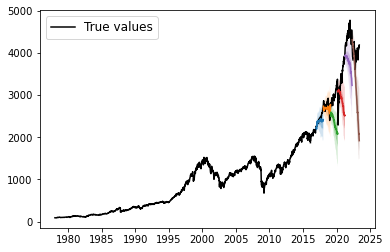

In [17]:
# Plot forecast
plot_forecast(
    tss=tss, 
    forecasts=forecasts, 
    # path="./6year_test.svg",
)

In [ ]:
import pickle

with open('6year_test_tss.pkl', 'wb') as outp:
    pickle.dump(tss, outp, pickle.HIGHEST_PROTOCOL)

with open('6year_test_forecasts.pkl', 'wb') as outp:
    pickle.dump(forecasts, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Add experiment to database store
experiment_config = Forecast_Experiment(
    model = 'torch_deepar',
    version = version,
    data_config = {
        'target':target_col,
        'past_rts_col':past_rts_col,
        'windows':windows,
    },
    model_config = {
        'epochs':max_epochs,
        'prediction_length':prediction_length,
        'num_layers':num_layers,
        'hidden_size':hidden_size,
        'context_length':context_length,
        'lr':lr,
        'weight_decay':weight_decay,
    },
    MASE = agg_metrics['MASE'],
    MAPE = agg_metrics['MAPE'],
    RMSE = agg_metrics['RMSE'],
    wQL_10 = agg_metrics['wQuantileLoss[0.1]'],
    wQL_50 = agg_metrics['wQuantileLoss[0.5]'],
    wQL_90 = agg_metrics['wQuantileLoss[0.9]'],
    avg_wQL = agg_metrics['mean_wQuantileLoss']
)
session.add(experiment_config)
session.commit()

In [ ]:
"hi"

## DeepState ([mx](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/deepstate/_estimator.py))

DeepState is a novel approach to probabilistic time series forecasting that combines state space models with deep learning. By parametrizing a per-time-series linear state space model with a jointly-learned recurrent neural network, our method retains desired properties of state space models such as data efficiency and interpretability, while making use of the ability to learn complex patterns from raw data offered by deep learning approaches.

In [9]:
from gluonts.mx import DeepStateEstimator
from gluonts.mx import Trainer

In [10]:
# Data specs
input_paths = [
    "../data_engineering/financial_ts/indices.csv",
    "../data_engineering/financial_ts/ww_gdp.csv",
    "../data_engineering/timeseries_data/ts_dgelt_events.csv"
]
target_col = 'ts_MSCI_World'
with open('./config/past_rts_cols.json', 'r') as fp:
    past_rts_col = json.load(fp)['version_1']
windows = 1

# Estimator specs
version = 1
prediction_length=56
num_layers=2
hidden_size=20

# Trainer specs
max_epochs = 100
lr = 1e-1
weight_decay = 1e-4

In [11]:
# Define estimator
deepstate_estimator = DeepStateEstimator(
    prediction_length=prediction_length,
    num_layers=num_layers, 
    num_cells=hidden_size, 
    use_feat_static_cat=False,
    cardinality=[],
    trainer = Trainer(
        epochs=max_epochs,
        learning_rate=lr,
        weight_decay=weight_decay,
    ),
    freq="W",
)

In [ ]:
# Start Experiment
forecasts, tss, agg_metrics = run_experiment(
    input_paths=input_paths,
    target_col=target_col,
    prediction_length=prediction_length,
    windows=windows,
    past_rts_col=past_rts_col,
    estimator=deepstate_estimator,
)

100%|██████████| 50/50 [01:33<00:00,  1.87s/it, epoch=100/100, avg_epoch_loss=4.13]
Running evaluation: 1it [00:00,  3.58it/s]


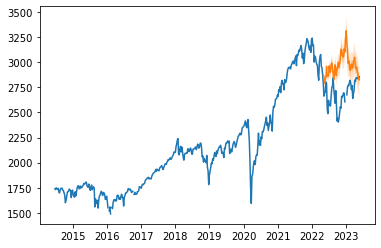

In [13]:
# Plot forecast
plot_forecast(
    tss=tss, 
    forecasts=forecasts, 
    # path="./plot.svg",
)

In [14]:
# Add experiment to database store
experiment_config = Forecast_Experiment(
    model = 'mx_deepstate',
    version = version,
    data_config = {
        'target':target_col,
        'past_rts_col':past_rts_col,
        'windows':windows,
    },
    model_config = {
        'epochs':max_epochs,
        'prediction_length':prediction_length,
        'num_layers':num_layers,
        'hidden_size':hidden_size,
        'lr':lr,
        'weight_decay':weight_decay,
    },
    MASE = agg_metrics['MASE'],
    MAPE = agg_metrics['MAPE'],
    RMSE = agg_metrics['RMSE'],
    wQL_10 = agg_metrics['wQuantileLoss[0.1]'],
    wQL_50 = agg_metrics['wQuantileLoss[0.5]'],
    wQL_90 = agg_metrics['wQuantileLoss[0.9]'],
    avg_wQL = agg_metrics['mean_wQuantileLoss']
)
session.add(experiment_config)
session.commit() 

## MQ-CNN ([mx](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/seq2seq/_mq_dnn_estimator.py))

MQ-CNN is a general probabilistic multi-step time series regression model. It exploits the expressiveness and temporal nature of Sequence-to-Sequence Neural Networks (e.g. recurrent and convolutional structures), the nonparametric nature of Quantile Regression and the efficiency of Direct Multi-Horizon Forecasting.


In [6]:
from gluonts.mx import MQCNNEstimator
from gluonts.mx import Trainer
import mxnet as mx

In [7]:
# Data specs
input_paths = [
    "../data_engineering/financial_ts/indices.csv",
    "../data_engineering/financial_ts/ww_gdp.csv",
    "../data_engineering/timeseries_data/ts_dgelt_events.csv"
]
target_col = 'ts_MSCI_World'
with open('./config/past_rts_cols.json', 'r') as fp:
    past_rts_col = json.load(fp)['version_1']
windows = 1

# Estimator specs
version = 1
prediction_length=56
decoder_mlp_dim_seq=[30]
channels_seq=[30,30,30]
use_past_feat_dynamic_real=True
context_length=50

# Trainer specs
max_epochs = 200
lr = 1e-1
weight_decay = 1e-4
ctx = mx.cpu() # mx.gpu()

In [8]:
mqcnn_estimator = MQCNNEstimator(
    prediction_length=prediction_length,
    channels_seq=channels_seq,  
    use_past_feat_dynamic_real=use_past_feat_dynamic_real,
    decoder_mlp_dim_seq=decoder_mlp_dim_seq, 
    context_length=context_length,
    freq="W",
    trainer=Trainer(
        ctx=ctx,
        epochs=max_epochs,
        learning_rate=lr,
        weight_decay=weight_decay,
    ),
)

In [ ]:
# Start Experiment
forecasts, tss, agg_metrics = run_experiment(
    input_paths=input_paths,
    target_col=target_col,
    prediction_length=prediction_length,
    windows=windows,
    past_rts_col=past_rts_col,
    estimator=mqcnn_estimator,
)

100%|██████████| 50/50 [00:29<00:00,  1.70it/s, epoch=200/200, avg_epoch_loss=1.35]
Running evaluation: 1it [00:00,  6.59it/s]


In [4]:
# Plot forecast
plot_forecast(
    tss=tss, 
    forecasts=forecasts, 
    # path="./plot.svg",
)

NameError: name 'tss' is not defined

In [ ]:
# Add experiment to database store
experiment_config = Forecast_Experiment(
    model = 'mx_cnnqr',
    version = version,
    data_config = {
        'target':target_col,
        'past_rts_col':past_rts_col,
        'windows':windows,
    },
    model_config = {
        'epochs':max_epochs,
        'prediction_length':prediction_length,
        'channels_seq':channels_seq,
        'decoder_mlp_dim_seq':decoder_mlp_dim_seq,
        'use_past_feat_dynamic_real':use_past_feat_dynamic_real,
        'context_length':context_length,
        'lr':lr,
        'weight_decay':weight_decay,
    },
    MASE = agg_metrics['MASE'],
    MAPE = agg_metrics['MAPE'],
    RMSE = agg_metrics['RMSE'],
    wQL_10 = agg_metrics['wQuantileLoss[0.1]'],
    wQL_50 = agg_metrics['wQuantileLoss[0.5]'],
    wQL_90 = agg_metrics['wQuantileLoss[0.9]'],
    avg_wQL = agg_metrics['mean_wQuantileLoss']
)
session.add(experiment_config)
session.commit() 
print("done")